In [4]:
# Decision Tree made for analysing data and its labels. All attributes are recommended to be numerical. 
# Gini index of the related nodes is considered to achieve the largest information gain to select the best splits.

import numpy as np

class Decision_Tree():
    def __init__(self, training_data, training_labels, test_data, test_labels, min_training_gini = 0.01): 
        # initiate the decision tree with all the training data & labels, set an optional min_training_gini value
        self.training_data = training_data
        self.training_labels = training_labels
        self.test_data = test_data
        self.test_labels = test_labels
        self.min_training_gini = min_training_gini

                
    def train(self):
        # create the root node
        self.root = Node(data = self.training_data, labels = self.training_labels)
        # make this part below recallable
        key_node = self.root
        gini_of_key_node = self.gini(key_node.labels)
        if gini_of_key_node < self.min_training_gini: 
            print('the requested min gini is too high, decrease the min required gini for splits')
            return
        if len(key_node.labels) <= 1: return
        assert(key_node.data != None).all() 
        if gini_of_key_node > self.min_training_gini:
            self.split(key_node)
    
    
    def split(self, key_node):
        # if there is not enough data to split, return
        # if gini is reaching the min standard, assign the label of the node 
        if len(key_node.labels) <= 1 or self.gini(key_node.labels) <= self.min_training_gini:
            key_node.node_id = self.most_common_label(key_node.labels)
            return 
        else:
            # do the split
            split_loc, split_value, True_list, True_label, False_list, False_label = self.best_split(key_node.data, key_node.labels)
            # assign the attributes to the key_node that is split into two parts
            key_node.split_loc = split_loc
            key_node.split_value = split_value
            
            # if split does not yield two seperate nodes, give an ID to the node and return
            if True_list == None or False_list == None: # No need to branch out
                key_node.node_id = self.most_common_label(key_node.labels)
                return
            
            else:
                # create a node, assign the attributes to the leftchild, connect with the parent node
                new_node = Node(data = True_list, labels = True_label, parent_T_F = True)
                new_node.parent = key_node
                key_node.leftchild = new_node

                # create a node, assign the attributes to the rightchild, connect with the parent node
                new_node = Node(data = False_list, labels = False_label, parent_T_F = False)
                new_node.parent = key_node
                key_node.rightchild = new_node
            
        # create branches recursively
        self.split(key_node.leftchild)
        self.split(key_node.rightchild)
    
 
    
    def test(self, test_data, test_labels):
        self.test_results = []
        for each_instance in test_data: # test each instance 
            current_node = self.root
            if self.root == None: return
            while current_node.leftchild != None and current_node.rightchild != None:
                # split_loc, split_value, split_T_F will be imported
                if current_node.split_value < each_instance[current_node.split_loc]: # go to the leftchild
                    current_node = current_node.leftchild
                else: # go to the rightchild
                    current_node = current_node.rightchild
            self.test_results.append(current_node.node_id)
        accuracy_of_test_data = self.accuracy(self.test_results, self.test_labels)     
        return accuracy_of_test_data
        
        
    def predict(self, data_to_be_labeled): # takes a 2d array with multiple instances and outputs predicted labels
        pred_results = []
        for each_instance in data_to_be_labeled: # test each instance 
            current_node = self.root
            while current_node.leftchild != None and current_node.rightchild != None:
                # split_loc, split_value, split_T_F will be imported
                if current_node.split_value < each_instance[current_node.split_loc]: # go to the leftchild
                    current_node = current_node.leftchild
                else: # go to the rightchild
                    current_node = current_node.rightchild
            if current_node.node_id != None:
                pred_results.append(current_node.node_id)   
        return pred_results
        
        
    def class_count(self, labels): # counts the number of labels in the target data (label list)
        a_dict = {}
        for label in labels:
            if label in a_dict.keys():
                a_dict[label] += 1
            else:
                a_dict[label] = 1
        return a_dict


    def most_common_label(self, labels): # returns the most commonly seen item in an array
        a_dict = self.class_count(labels)
        most_common = 0
        for k,v in a_dict.items():
            if v > most_common:
                most_common = v
                set_the_most_freq_item = k
        return set_the_most_freq_item

    
    def gini(self, labels): # calculates the impurity of the target list
        count = self.class_count(labels)
        gini_impurity = 1
        for k,v in count.items():
            prob = v / len(labels)
            gini_impurity -= prob**2
        return gini_impurity


    def information_gain(self, labels, T_labels, F_labels): 
        # after the split is done, compare the differences in gini and output the information gain
        T_len = len(T_labels)
        F_len = len(F_labels)
        total_len = len(labels)
        info_gain = self.gini(labels) - (T_len/total_len * self.gini(T_labels)) - (F_len/total_len * self.gini(F_labels))
        return info_gain


    def partition(self, data, labels, column, value): # does partition based on the specified column's value
        assert(len(data) == len(labels))
        if len(data) <= 1: return
        T_data, T_label, F_data, F_label = [], [], [], [] # both the data and labels will split into two lists
        for i in range(len(data)):
            if data[i][column] >= value:
                T_data.append(data[i])
                T_label.append(labels[i])
            else:
                F_data.append(data[i])
                F_label.append(labels[i])
        return T_data, T_label, F_data, F_label


    def best_split(self, data, labels): # decides which attribute is the best for the split that yields highest info gain
        if len(data) <= 1: return # not enough data, terminate the function
        if len(set(labels)) == 1: return None # there is nothing to split, return None
        max_info_gain = 0
        # loop over all columns of data
        for att_loc in range(len(data[0])):
            # find all the atttributes in each column
            set_of_att = set([row[att_loc] for row in data])
            # for each instance
            for each_att in set_of_att:
                # do the partition for column and attributes
                T_data, T_label, F_data, F_label = self.partition(data, labels, att_loc, each_att)
                info_gain = self.information_gain(labels, T_label, F_label)
                if info_gain > max_info_gain:
                    max_info_gain = info_gain
                    best_split_loc = att_loc
                    best_split_att = each_att
                    True_list = T_data
                    False_list = F_data
                    True_label = T_label
                    False_label = F_label
        # return the best split's attributes and the T and F lists based on the best info gain achieved
        return (best_split_loc, best_split_att, True_list, True_label, False_list, False_label)



    # accuracy will be calculated by comparing obtained targets with the actual labels 
    # Ex: accuracy(our_obtained_target_list, actual_labels) for the accuracy  
    def accuracy(self, testing_labels, actual_labels):
        assert (len(testing_labels) == len(actual_labels))
        testing_labels = np.array(testing_labels)
        actual_labels = np.array(actual_labels)
        matching_labels = (testing_labels == actual_labels) 
        # this will output an array with False and True results for each labels 
        accuracy_of_model = sum(matching_labels) / len(testing_labels)
        return accuracy_of_model * 100

    
    

class Node():
    def __init__(self, data = None, labels = None, parent = None, node_id = None,
                 leftchild = None, rightchild = None, split_loc = None, split_value = None, parent_T_F = None):
    
        self.data = data
        self.labels = labels
        self.parent = parent
        self.node_id = node_id
        self.leftchild = leftchild
        self.rightchild = rightchild
        self.split_loc = split_loc
        self.split_value = split_value
        self.parent_T_F = parent_T_F
        


In [7]:
# upload the data
# IRIS dataset is chosen for training, testing and predictions

import matplotlib.pyplot as plt
from sklearn import datasets
%matplotlib inline

# import Iris Dataset 
iris = datasets.load_iris()
data = iris.data  # we only take the first two features.
labels = iris.target

# take a look at the data
print(len(data))
print(data[0:5])
print(labels[0:5])

# shuffle both the data and its labels 
random_indices = np.random.permutation(len(data))
print(random_indices[:5])
data = data[random_indices]
labels = labels[random_indices]

# fix the randomly chosen samples, so that they will not keep shuffling everytime the cell is executed
np.random.seed(0)

# take a look at the shuffled data
print(data[:10])
print(labels[:10])

# split the data for training and testing. 
# Build the model with training set and then check the accuracy with testing set
# use 80 percent of the data for training and 20 percent for testing
training_data = data[:140] 
training_labels = labels[:140]
test_data = data[140:]
test_labels = labels[140:]
#prediction_data = data[140:]
#prediction_labels = labels[140:]
#len(prediction_data) == len(prediction_labels)




150
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
[0 0 0 0 0]
[114  62  33 107   7]
[[5.8 2.8 5.1 2.4]
 [6.  2.2 4.  1. ]
 [5.5 4.2 1.4 0.2]
 [7.3 2.9 6.3 1.8]
 [5.  3.4 1.5 0.2]
 [6.3 3.3 6.  2.5]
 [5.  3.5 1.3 0.3]
 [6.7 3.1 4.7 1.5]
 [6.8 2.8 4.8 1.4]
 [6.1 2.8 4.  1.3]]
[2 1 0 2 0 2 0 1 1 1]


20 20
[60.0, 60.0, 60.0, 60.0, 60.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 80.0, 80.0]
[60.0, 60.0, 60.0, 60.0, 60.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 80.0, 80.0]
[0.65       0.61584211 0.58168421 0.54752632 0.51336842 0.47921053
 0.44505263 0.41089474 0.37673684 0.34257895 0.30842105 0.27426316
 0.24010526 0.20594737 0.17178947 0.13763158 0.10347368 0.06931579
 0.03515789 0.001     ]


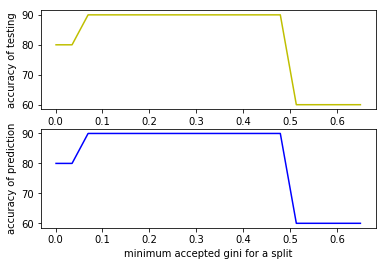

In [8]:

# test the decision tree with different gini for splits for optimal gini index 
if __name__== '__main__':
    gini_values = np.linspace(0.65, 0.001, 20)
    #print(prediction_data, prediction_labels)
    #print(training_gini)
    testing_results = []
    prediction_accuracy = []
    for each_min_gini in gini_values:
        # output the test and prediction scores based on the different min accepted gini level for a split 
        test_D_T = Decision_Tree(training_data, training_labels, test_data, test_labels, min_training_gini = each_min_gini)     
        test_D_T.train()
        test_accuracy = test_D_T.test(test_data, test_labels)
        pred_results = test_D_T.predict(prediction_data)
        pred_accuracy = test_D_T.accuracy(pred_results, prediction_labels)
        testing_results.append(test_accuracy)
        prediction_accuracy.append(pred_accuracy)

    print(len(testing_results) , len(prediction_accuracy))

    print(testing_results)
    print(prediction_accuracy)
    print(gini_values)
    plt.subplot(2,1,1)
    plt.plot(gini_values, testing_results, 'y-')
    plt.xlabel('minimum accepted gini for a split') 
    plt.ylabel('accuracy of testing')
    plt.subplot(2,1,2)
    plt.plot(gini_values, prediction_accuracy, 'b-')
    plt.xlabel('minimum accepted gini for a split') 
    plt.ylabel('accuracy of prediction')
    
